# Grid Sampling

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import cm
from scipy.stats import qmc
from common.plotting import plot_single_heatmap_2d

In [2]:
# Set number of data points
N_0 = 50
N_b = 50
N_d = 0
N_r = 10000

# Set boundary
tmin = 0.
tmax = 1.
xmin = -1.
xmax = 1.

t_r = np.linspace(tmin, tmax, N_r + 1)
x_r = np.linspace(xmin, xmax, N_r + 1)
T, X = np.meshgrid(t_r, x_r)

In [3]:
def plot_grid(X, ax=None, title=None, cmap=plt.get_cmap('RdYlBu')):
    if ax is None:
        _, ax = plt.subplots()
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], s=20, cmap=cmap,
               edgecolors='k', linewidth=0.5)
    ax.set_xlim(tmin, tmax)
    ax.set_ylim(xmin, xmax)
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.set_title(title)
    return ax

## Sobol Sequence

In [4]:
sobol_sampler = qmc.Sobol(d=2, scramble=False)
x_sobol = sobol_sampler.random(n=1000)
x_sobol = qmc.scale(x_sobol, [tmin, xmin], [tmax, xmax])

C:\Users\ritka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


C:\Users\ritka\AppData\Local\Temp\ipykernel_19056\2271300588.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[:, 0], X[:, 1], s=20, cmap=cmap,


<Axes: title={'center': 'Sobol Sampling'}, xlabel='$t$', ylabel='$x$'>

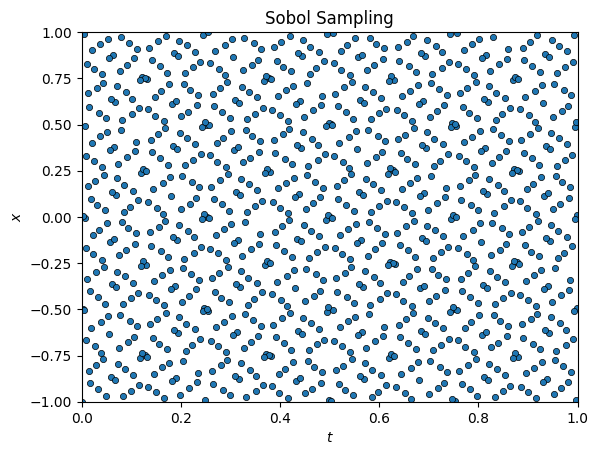

In [5]:
plot_grid(x_sobol, None, title='Sobol Sampling')

## RAD

In [6]:
def toy_residual(x, y):
    return (x - 0.5)**2 + (y)**2

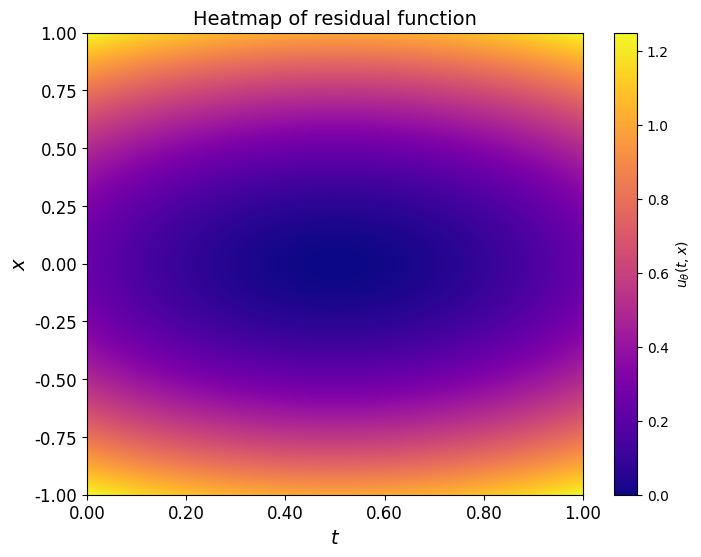

In [7]:
# Используем просто ради примера сетку соболя
U = toy_residual(T, X)
plot_single_heatmap_2d(T, X, U, title='Heatmap of residual function', cmap="plasma")

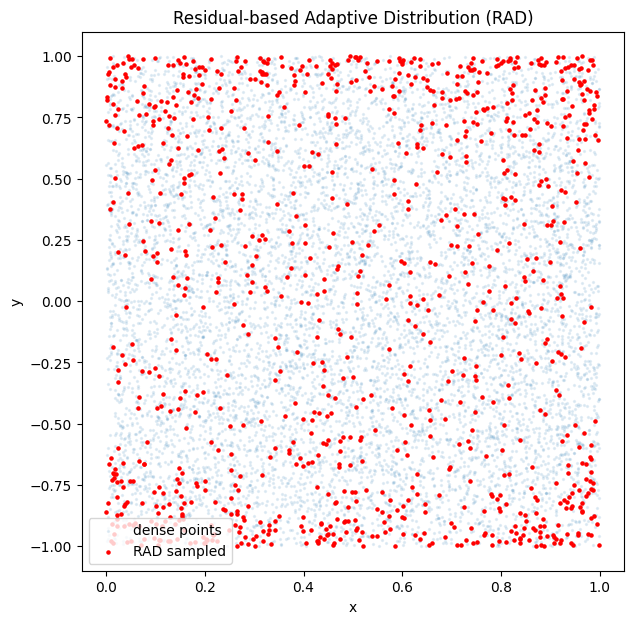

In [8]:
k = 3       # гиперпараметр k в формуле
c = 1      # гиперпараметр c в формуле
n_dense = 10000 # густая сетка для оценки распределения
n_sample = 1000 # сколько точек выбрать для обучения
dim = 2
l_bounds = np.array([tmin, xmin])  # нижняя граница области
u_bounds = np.array([tmax, xmax])  # верхняя граница области

# Генерируем густые точки в [l_bounds, u_bounds]
dense_points = np.random.uniform(l_bounds, u_bounds, (n_dense, dim))

# Считаем невязку для всех точек (в реальности - берем из вашей PINN модели)
eps = toy_residual(dense_points[:, 0], dense_points[:, 1])  # shape (n_dense,)

# Считаем вероятности по формуле RAD
eps_k = eps ** k
mean_eps_k = np.mean(eps_k)
probs = eps_k / mean_eps_k + c
# нормируем, чтобы это была вероятность
probs /= np.sum(probs)

# Сэмплируем из густой сетки обучающие точки согласно probs
chosen_idxs = np.random.choice(n_dense, size=n_sample, replace=False, p=probs)
rad_points = dense_points[chosen_idxs, :]

# Визуализация
plt.figure(figsize=(7, 7))
plt.scatter(dense_points[:, 0], dense_points[:, 1], alpha=0.1, label='dense points', s=2)
plt.scatter(rad_points[:, 0], rad_points[:, 1], color='red', label='RAD sampled', s=5)
plt.xlabel('x'); plt.ylabel('y'); plt.title('Residual-based Adaptive Distribution (RAD)')
plt.legend()
plt.show()

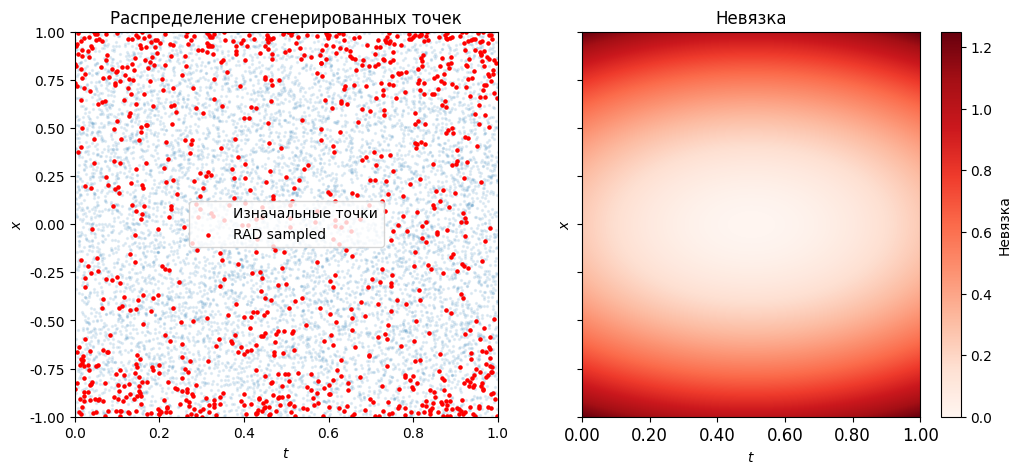

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

ax[0].scatter(dense_points[:, 0], dense_points[:, 1], alpha=0.1, label='Изначальные точки', s=2)
ax[0].scatter(rad_points[:, 0], rad_points[:, 1], color='red', label='RAD sampled', s=5)
ax[0].set_xlabel('$t$')
ax[0].set_ylabel('$x$')
ax[0].set_xlim([tmin, tmax])
ax[0].set_ylim([xmin, xmax])
ax[0].set_title('Распределение сгенерированных точек')
ax[0].legend()


im = ax[1].imshow(
    U, extent=[T.min(), T.max(), X.min(), X.max()],
    origin='lower', aspect='auto', cmap='Reds'
)
fig.colorbar(im, ax=ax[1], label='Невязка')
ax[1].tick_params(axis='x', labelsize=12)
ax[1].tick_params(axis='y', labelsize=12)
ax[1].set_title('Невязка')
ax[1].set_xlabel('$t$')
ax[1].set_ylabel('$x$')
ax[1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.2f}'))  # Format x-axis as float with 2 decimals
ax[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y:.2f}'))  # Format y-axis as float with 2 decimals

# Обучение RFF-PINN

In [10]:
import torch
import torch.autograd as autograd
from torch.optim.lr_scheduler import LambdaLR, StepLR
import torch.optim as optim
import random 
import numpy as np

from tasks.burgers_1d import Burgers1D
from models.sapinn import SA_PINN
from models.pinn import PINN
from models.utils.schedulers import LambdaScheduler
from models.utils.masks import PolynomialMask, SigmoidMask, LinearMask
from common.train_functions import *
from common.plotting import *
from common.saving_results import *

In [11]:
# Fix random number generators
seed = 42
torch.manual_seed(seed)  # For PyTorch
random.seed(seed)        # For random
np.random.seed(seed)     # For NumPy

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [13]:
viscosity = 0.01 / np.pi
burgers_1d = Burgers1D(nu=viscosity)

# Set boundaries
lb = torch.tensor([tmin, xmin], dtype=torch.float32, requires_grad=False)  # Lower bounds
ub = torch.tensor([tmax, xmax], dtype=torch.float32, requires_grad=False)  # Upper bounds

# Generate points for initial conditions
t_0 = torch.ones((N_0, 1), dtype=torch.float32, requires_grad=True) * lb[0]
x_0 = torch.rand((N_0, 1), dtype=torch.float32, requires_grad=True) * (ub[1] - lb[1]) + lb[1]
X_0 = torch.cat([t_0, x_0], dim=1)

# Compute initial condition at points x_0
u_0 = burgers_1d.initial_conditions(x_0)

# Generate points for boundary conditions
t_b = torch.rand((N_b, 1), dtype=torch.float32, requires_grad=True) * (ub[0] - lb[0]) + lb[0]
x_b = lb[1] + (ub[1] - lb[1]) * torch.bernoulli(torch.full((N_b, 1), 0.5, dtype=torch.float32))
x_b.requires_grad_(True)  # Set requires_grad=True for x_b
X_b = torch.cat([t_b, x_b], dim=1)

# Compute boundary condition at points (t_b, x_b)
u_b = burgers_1d.boundary_conditions(t_b)

# Generate points for collocation
t_r = torch.rand((N_r, 1), dtype=torch.float32, requires_grad=True) * (ub[0] - lb[0]) + lb[0]
x_r = torch.rand((N_r, 1), dtype=torch.float32, requires_grad=True) * (ub[1] - lb[1]) + lb[1]
X_r = torch.cat([t_r, x_r], dim=1)

In [14]:
N = 500
rff_features = 20
rff_layers = 9
lambda_step_size = 100
lambda_lr = 1e-4
weight_gamma = 0.85
max_epoch = 10000

In [15]:
# Set training parameters
rff_pinn = PINN(
    input_dim=2,
    rff_features=rff_features,
    output_dim=1,
    hidden_layers= 9 * [2 * rff_features + 2],
    equation=burgers_1d
).to(device)
optimizers = {
    "model": optim.Adam(rff_pinn.parameters(), lr=1e-3),
}
scheduler = {
    "model": optim.lr_scheduler.StepLR(optimizers["model"], step_size=1000, gamma=weight_gamma)
}

In [16]:
rff_pinn.to(device)
train_loss, eval_losses = train_pinn(
    max_epoch, 
    rff_pinn, optimizers, scheduler,
    X_r, X_0, X_b, 
    x_data = None, u_data = None, device=device
)

C:\Users\ritka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\autograd\graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 50/10000, PINN Loss: 0.19151, True Loss: 0.19265
Epoch: 100/10000, PINN Loss: 0.15882, True Loss: 0.15882
Epoch: 150/10000, PINN Loss: 0.15753, True Loss: 0.15750
Epoch: 200/10000, PINN Loss: 0.15592, True Loss: 0.15588
Epoch: 250/10000, PINN Loss: 0.15264, True Loss: 0.15252
Epoch: 300/10000, PINN Loss: 0.14500, True Loss: 0.14009
Epoch: 350/10000, PINN Loss: 0.11193, True Loss: 0.11136
Epoch: 400/10000, PINN Loss: 0.08064, True Loss: 0.07707
Epoch: 450/10000, PINN Loss: 0.06848, True Loss: 0.11073
Epoch: 500/10000, PINN Loss: 0.04825, True Loss: 0.04440
Epoch: 550/10000, PINN Loss: 0.03783, True Loss: 0.03520
Epoch: 600/10000, PINN Loss: 0.03138, True Loss: 0.05637
Epoch: 650/10000, PINN Loss: 0.02790, True Loss: 0.02859
Epoch: 700/10000, PINN Loss: 0.03156, True Loss: 0.02568
Epoch: 750/10000, PINN Loss: 0.02369, True Loss: 0.02313
Epoch: 800/10000, PINN Loss: 0.02378, True Loss: 0.02178
Epoch: 850/10000, PINN Loss: 0.02004, True Loss: 0.02000
Epoch: 900/10000, PINN Loss: 0.0

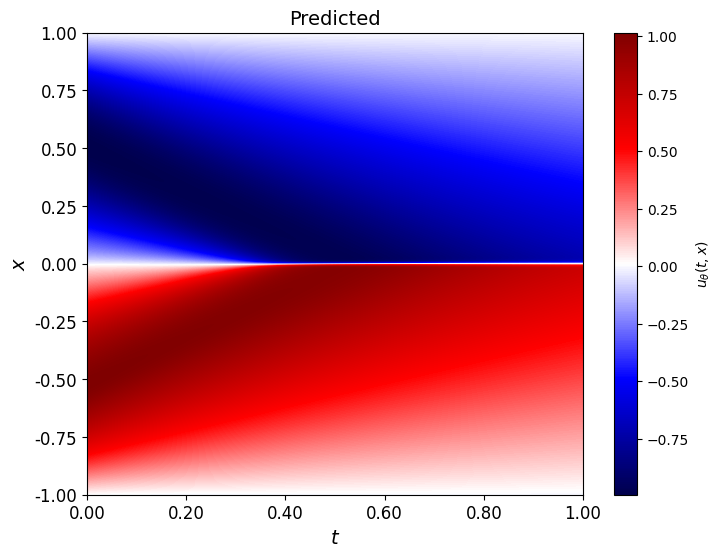

In [17]:
rff_pinn.to("cpu")
T, X, U = compute_approximation_2d(rff_pinn, lb, ub, N)
plot_single_heatmap_2d(T, X, U, title="Predicted") # save_path="../pics/1d_burgers/plots/sa_pinn_v001divpi.png")

In [19]:
rff_pinn.to(device)
rad_finetune_pinn(
    max_epoch, 
    rff_pinn, optimizers, scheduler,
    X_r, X_0, X_b, 
    x_data = None, u_data = None, device=device,
    resample_percent=0.5, k=2
)

Finetuning model on resampled data...
Epoch: 50/2000, PINN Loss: 0.00012, True Loss: 0.00012
Epoch: 100/2000, PINN Loss: 0.00012, True Loss: 0.00012
Epoch: 150/2000, PINN Loss: 0.00012, True Loss: 0.00012
Epoch: 200/2000, PINN Loss: 0.00012, True Loss: 0.00012
Epoch: 250/2000, PINN Loss: 0.00012, True Loss: 0.00012
Epoch: 300/2000, PINN Loss: 0.00012, True Loss: 0.00012
Epoch: 350/2000, PINN Loss: 0.00011, True Loss: 0.00011
Epoch: 400/2000, PINN Loss: 0.00011, True Loss: 0.00011
Epoch: 450/2000, PINN Loss: 0.00011, True Loss: 0.00011
Epoch: 500/2000, PINN Loss: 0.00011, True Loss: 0.00011
Epoch: 550/2000, PINN Loss: 0.00011, True Loss: 0.00011
Epoch: 600/2000, PINN Loss: 0.00012, True Loss: 0.00011
Epoch: 650/2000, PINN Loss: 0.00011, True Loss: 0.00011
Epoch: 700/2000, PINN Loss: 0.00011, True Loss: 0.00011
Epoch: 750/2000, PINN Loss: 0.00011, True Loss: 0.00011
Epoch: 800/2000, PINN Loss: 0.00011, True Loss: 0.00011
Epoch: 850/2000, PINN Loss: 0.00013, True Loss: 0.00013
Epoch: 900/

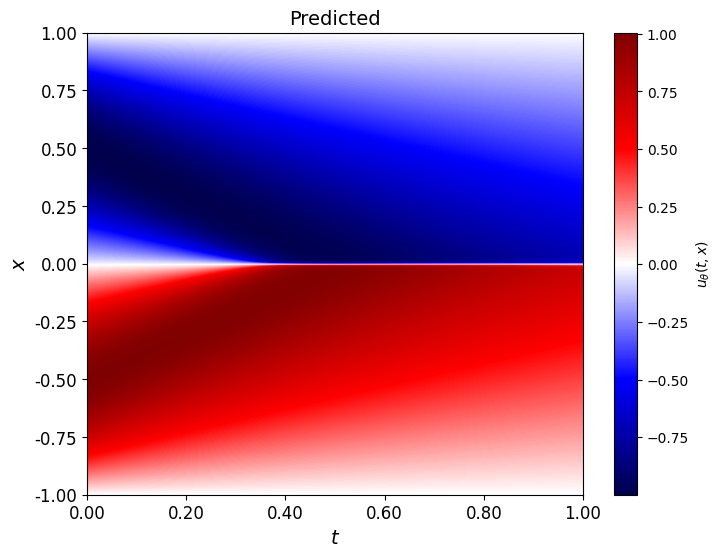

In [20]:
rff_pinn.to("cpu")
T, X, U = compute_approximation_2d(rff_pinn, lb, ub, N)
plot_single_heatmap_2d(T, X, U, title="Predicted") # save_path="../pics/1d_burgers/plots/sa_pinn_v001divpi.png")